## Outline

1. L2 norm and loading datasets
2. Modifying our FF Class
3. Use more complex models to reduce bias
4. Demonstrate overfitting for very large models
5. Use L2 regularisation for preventing overfitting
6. Use noise on training data for preventing overfitting
7. Exercises

## Setup

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm

In [87]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [88]:
np.random.seed(0)

## Generate data

In [108]:
iris=load_iris()
data = iris.data

# take only the first two features
labels = iris.target


In [109]:
print("Data shape",data.shape)
print("Labels shape",labels.shape)

Data shape (150, 4)
Labels shape (150,)


## Multi class classification

In [110]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0,test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)



(120, 4) (30, 4) (150,)


In [111]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)


c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this 

(120, 3) (30, 3)


## FF Class

In [131]:
class FFNetwork:
  
  def __init__(self,ip=2,op=3, num_hidden=2, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
        
    self.params={}
    self.num_layers=2
    self.layer_sizes = [ip, num_hidden, op]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    np.random.seed(0)
    
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
    for i in range(1,self.num_layers+1):
        print(i)
        print(self.params["W"+str(i)])
        print(i)
        print(self.params["B"+str(i)])
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
    
  def get_accuracy(self):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val
    
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 2) -> (N, 2)
    self.H2 = self.softmax(self.A2) # (N, 2)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD",l2_norm=False, lambda_val=0.8, display_loss=False, eta=1):
    train_accuracies={}
    val_accuracies={}
    if display_loss:
      loss = []
      weight_mag = []
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      self.grad(X, Y)
      for i in range(1,self.num_layers+1):
        if l2_norm:
          self.params["W"+str(i)] -= (eta * lambda_val)/m * self.params["W"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
        else:
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      train_accuracy,val_accuracy=self.get_accuracy()
      train_accuracies[num_epoch]=train_accuracy
      val_accuracies[num_epoch]=val_accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
        weight_mag.append((norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"]))/18)
        
    plt.plot(train_accuracies.values(),label="Train accuracy")
    plt.plot(val_accuracies.values(),label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*0.33)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    if display_loss:
      fig, ax1 = plt.subplots()
      color = 'tab:red'
      ax1.set_xlabel('epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(loss, '-o', color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()  
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)  # we already handled the x-label with ax1
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout()  
      plt.show()

  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()                               

In [132]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

1
[[0.88202617]
 [0.2000786 ]
 [0.48936899]
 [1.1204466 ]]
1
[[1.86755799]]
2
[[-0.97727788  0.95008842 -0.15135721]]
2
[[-0.10321885  0.4105985   0.14404357]]


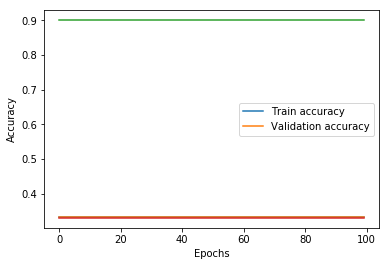

Training accuracy 0.3333
Validation accuracy 0.3333


In [133]:
model = FFNetwork(ip=4,num_hidden=1)

model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()


1
[[ 0.88202617  0.2000786   0.48936899  1.1204466 ]
 [ 0.933779   -0.48863894  0.47504421 -0.0756786 ]
 [-0.05160943  0.20529925  0.07202179  0.72713675]
 [ 0.38051886  0.06083751  0.22193162  0.16683716]]
1
[[ 1.49407907 -0.20515826  0.3130677  -0.85409574]]
2
[[-1.27649491  0.3268093   0.4322181 ]
 [-0.37108251  1.13487731 -0.72718284]
 [ 0.02287926 -0.09359193  0.76638961]
 [ 0.73467938  0.07747371  0.18908126]]
2
[[-0.88778575 -1.98079647 -0.34791215]]


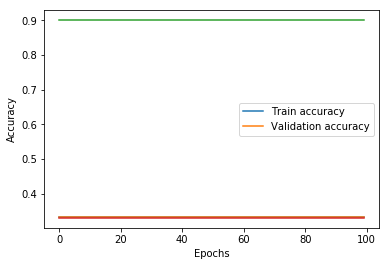

Training accuracy 0.3333
Validation accuracy 0.3333


In [134]:
model = FFNetwork(ip=4,num_hidden=4)

model.fit(X_train, y_OH_train, epochs=100, eta=5)
print_accuracy()


1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786 ]
 [-0.05160943  0.20529925  0.07202179  0.72713675  0.38051886  0.06083751
   0.22193162  0.16683716]
 [ 0.74703954 -0.10257913  0.15653385 -0.42704787 -1.27649491  0.3268093
   0.4322181  -0.37108251]
 [ 1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126]]
1
[[-0.88778575 -1.98079647 -0.34791215  0.15634897  1.23029068  1.20237985
  -0.38732682 -0.30230275]]
2
[[-0.37071946 -0.50205216 -0.60325761]
 [ 0.68970326 -0.18018926 -0.15488265]
 [-0.44293005  0.27488435 -0.57059906]
 [-0.07521505 -0.31659524  0.13679069]
 [-0.18059689 -0.41741651 -0.00996392]
 [ 0.15143819  0.02351739  0.10693997]
 [-0.22426673 -0.12824837 -0.23775067]
 [-0.12712124 -0.28749063 -0.61033307]]
2
[[ 0.17742614 -0.40178094 -1.63019835]]


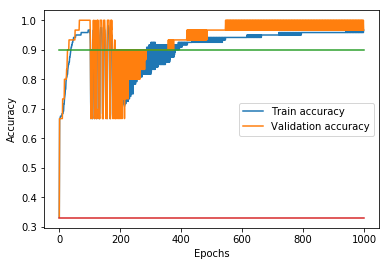

Training accuracy 0.9667
Validation accuracy 0.9667


In [138]:
model = FFNetwork(ip=4,num_hidden=8)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, display_loss=False)
print_accuracy()

1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126]
 [-0.44389287 -0.99039823 -0.17395607  0.07817448  0.61514534  0.60118992
  -0.19366341 -0.15115138 -0.52427648 -0.71000897 -0.8531351   0.9753877
  -0.25482609 -0.21903715 -0.62639768  0.38874518 -0.80694892 -0.10637014
  -0.44773328  0.19345125 -0.25540257 -0.59031609 -0.01409111  0.21416594
   0.03325861  0.15123595 -0.31716105 -0.18137058 -0.33623022 -0.17977658
  -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.58257

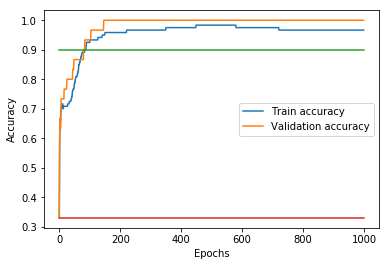

Training accuracy 0.9667
Validation accuracy 1.0


In [140]:
model = FFNetwork(4,num_hidden=32)

model.fit(X_train, y_OH_train, epochs=1000, eta=0.1)
print_accuracy()


1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.5825749

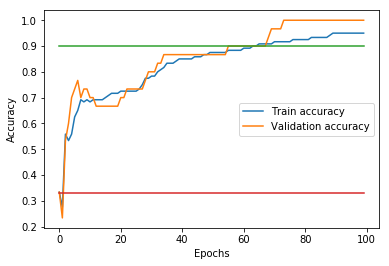

Training accuracy 0.95
Validation accuracy 1.0


In [141]:
model = FFNetwork(4,num_hidden=64)

model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()


## Add L2 Regularization

1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.5825749

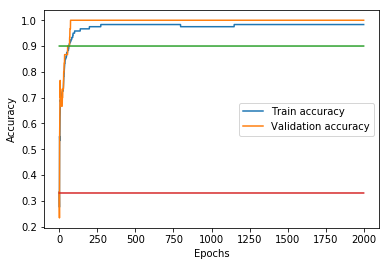

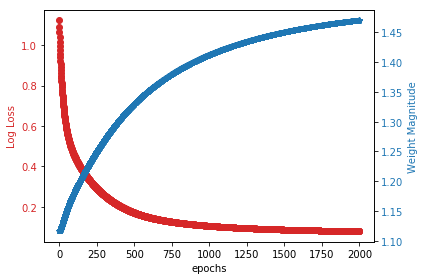

Training accuracy 0.9833
Validation accuracy 1.0


In [149]:

model = FFNetwork(4,num_hidden=64)

model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=0.1, display_loss=True)
print_accuracy()


1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.5825749

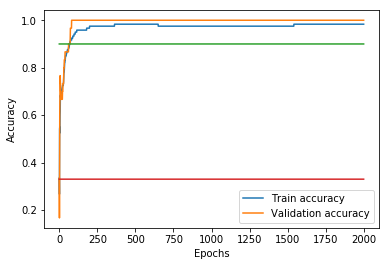

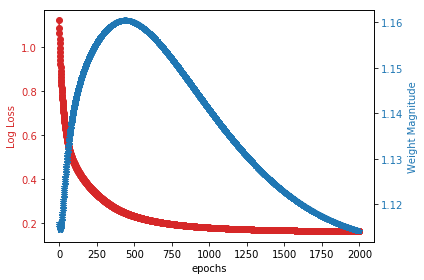

Training accuracy 0.9833
Validation accuracy 1.0


In [144]:
model = FFNetwork(4,num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=1, display_loss=True)
print_accuracy()

1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.5825749

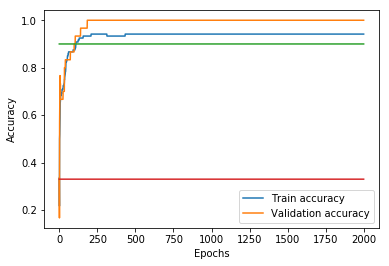

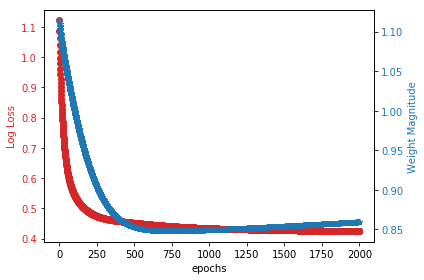

Training accuracy 0.9417
Validation accuracy 1.0


In [147]:
model = FFNetwork(4,num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=5, display_loss=True)
print_accuracy()

1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.5825749

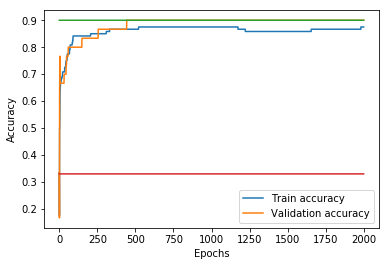

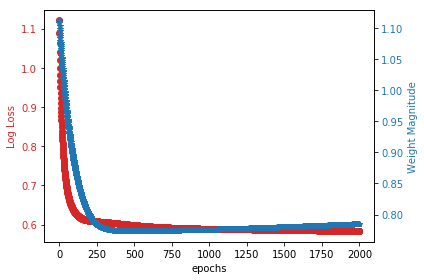

Training accuracy 0.875
Validation accuracy 0.9


In [146]:
model = FFNetwork(4,num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=10, display_loss=True)
print_accuracy()


## Add noise to training data set

1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.5825749

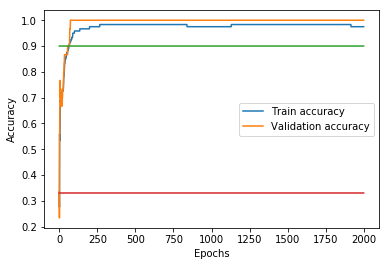

Training accuracy 0.975
Validation accuracy 1.0


In [148]:
model = FFNetwork(4,num_hidden=64)
model.fit(X_train, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
print_accuracy()

0.01
1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.58

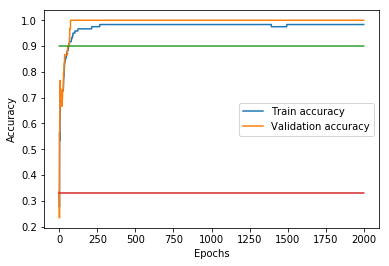

Training accuracy 0.9833
Validation accuracy 1.0
0.05
1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.4

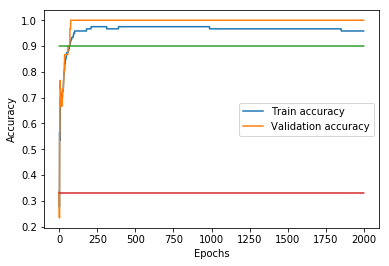

Training accuracy 0.9583
Validation accuracy 1.0
0.1
1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43

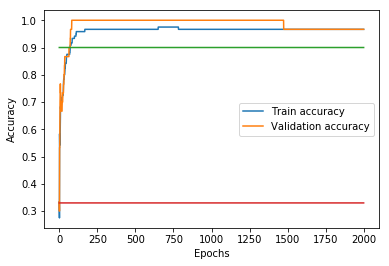

Training accuracy 0.9667
Validation accuracy 0.9667
0.15
1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -

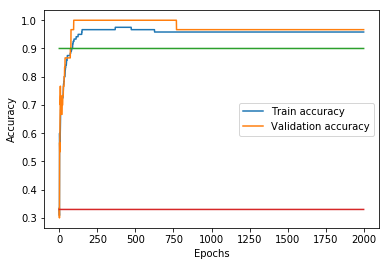

Training accuracy 0.9583
Validation accuracy 0.9667
0.18
1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -

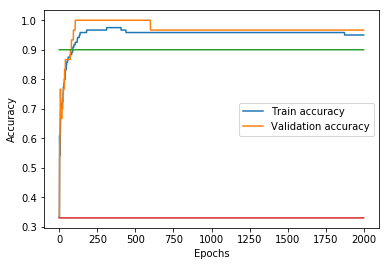

Training accuracy 0.95
Validation accuracy 0.9667
0.2
1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126 -0.44389287 -0.99039823 -0.17395607  0.07817448
   0.61514534  0.60118992 -0.19366341 -0.15115138 -0.52427648 -0.71000897
  -0.8531351   0.9753877  -0.25482609 -0.21903715 -0.62639768  0.38874518
  -0.80694892 -0.10637014 -0.44773328  0.19345125 -0.25540257 -0.59031609
  -0.01409111  0.21416594  0.03325861  0.15123595 -0.31716105 -0.18137058
  -0.33623022 -0.17977658 -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.4

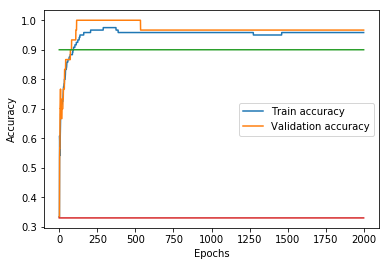

Training accuracy 0.9583
Validation accuracy 0.9667


In [151]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
  print(noise_fraction)
  X_train_noisy = X_train * (1 - noise_fraction*np.random.randn(X_train.shape[0], X_train.shape[1]))
  model = FFNetwork(4,num_hidden=64)
  model.fit(X_train_noisy, y_OH_train, epochs=2000, eta=0.1, l2_norm=False)
  print_accuracy()

## Early stopping

1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126]
 [-0.44389287 -0.99039823 -0.17395607  0.07817448  0.61514534  0.60118992
  -0.19366341 -0.15115138 -0.52427648 -0.71000897 -0.8531351   0.9753877
  -0.25482609 -0.21903715 -0.62639768  0.38874518 -0.80694892 -0.10637014
  -0.44773328  0.19345125 -0.25540257 -0.59031609 -0.01409111  0.21416594
   0.03325861  0.15123595 -0.31716105 -0.18137058 -0.33623022 -0.17977658
  -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.58257

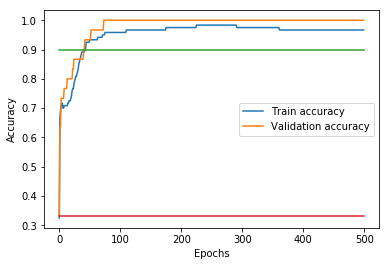

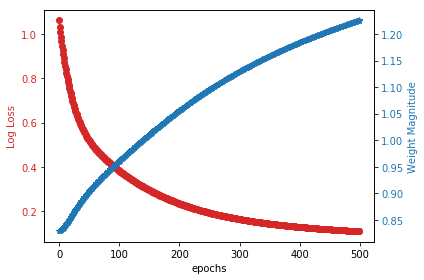

Training accuracy 0.9667
Validation accuracy 1.0


In [153]:
model = FFNetwork(4,num_hidden=32)
model.fit(X_train, y_OH_train, epochs=500, eta=0.2, display_loss=True)
print_accuracy()

1
[[ 0.88202617  0.2000786   0.48936899  1.1204466   0.933779   -0.48863894
   0.47504421 -0.0756786  -0.05160943  0.20529925  0.07202179  0.72713675
   0.38051886  0.06083751  0.22193162  0.16683716  0.74703954 -0.10257913
   0.15653385 -0.42704787 -1.27649491  0.3268093   0.4322181  -0.37108251
   1.13487731 -0.72718284  0.02287926 -0.09359193  0.76638961  0.73467938
   0.07747371  0.18908126]
 [-0.44389287 -0.99039823 -0.17395607  0.07817448  0.61514534  0.60118992
  -0.19366341 -0.15115138 -0.52427648 -0.71000897 -0.8531351   0.9753877
  -0.25482609 -0.21903715 -0.62639768  0.38874518 -0.80694892 -0.10637014
  -0.44773328  0.19345125 -0.25540257 -0.59031609 -0.01409111  0.21416594
   0.03325861  0.15123595 -0.31716105 -0.18137058 -0.33623022 -0.17977658
  -0.40657314 -0.8631413 ]
 [ 0.08871307 -0.20089047 -0.81509917  0.23139113 -0.45364918  0.0259727
   0.36454528  0.06449146  0.56970034 -0.61741291  0.20117082 -0.34240505
  -0.43539857 -0.28942483 -0.15577627  0.02808267 -0.58257

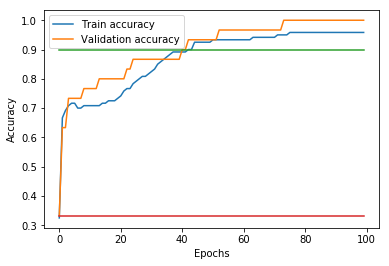

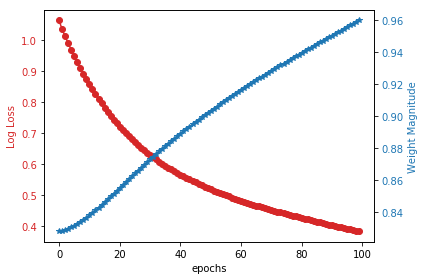

Training accuracy 0.9583
Validation accuracy 1.0


In [154]:
model = FFNetwork(4,num_hidden=32)
model.fit(X_train, y_OH_train, epochs=100, eta=0.2, display_loss=True)
print_accuracy()

## Exercises

* Repeat the above with at least one other activation function / initialisation method pair
* For the iris data-set, repeat the above with the entire data-set, i.e. not with just two inputs - modify the class to support that
* Repeat the above with at least one other data-set (eg. from sklearn.datasets) 
